# Support Vector Machines (SVM) para reconocimiento de imágenes
#### Por Camilo A. Aguilar L
Estos métodos están propiamente relacionados con problemas de clasificación y regresión. Dado un conjunto de ejemplos de entrenamiento (de muestras) podemos etiquetar las clases y entrenar una SVM para construir un modelo que prediga la clase de una nueva muestra. Intuitivamente, una SVM es un modelo que representa a los puntos de muestra en el espacio, separando las clases a 2 espacios lo más amplios posibles mediante un hiperplano de separación definido como el vector entre los 2 puntos, de las 2 clases, más cercanos al que se llama vector soporte. Cuando las nuevas muestras se ponen en correspondencia con dicho modelo, en función de los espacios a los que pertenezcan, pueden ser clasificadas a una o la otra clase.

Dado un conjunto de puntos, subconjunto de un conjunto mayor (espacio), en el que cada uno de ellos pertenece a una de dos posibles categorías, un algoritmo basado en SVM construye un modelo capaz de predecir si un punto nuevo (cuya categoría desconocemos) pertenece a una categoría o a la otra.
Como en la mayoría de los métodos de clasificación supervisada, los datos de entrada (los puntos) son vistos como un vector p-dimensional (una lista ordenada de p números).
La SVM busca un hiperplano que separe de forma óptima a los puntos de una clase de la de otra, que eventualmente han podido ser previamente proyectados a un espacio de dimensionalidad superior.
En ese concepto de "separación óptima" es donde reside la característica fundamental de las SVM: este tipo de algoritmos buscan el hiperplano que tenga la máxima distancia (margen) con los puntos que estén más cerca de él mismo. Por eso también a veces se les conoce a las SVM como clasificadores de margen máximo. De esta forma, los puntos del vector que son etiquetados con una categoría estarán a un lado del hiperplano y los casos que se encuentren en la otra categoría estarán al otro lado.

## MNIST
MNIST es una base de datos que contiene imágenes de números escritos a mano, donde cada imagen está etiquetada con un número entero. El dataset de MNIST contiene un conjunto de entrenamiento de 60.000 imágenes y un conjunto de pruebas de 10.000 ejemplos. El conjunto de entrenamiento es utilizado para enseñar al algoritmo a predecir la etiqueta correcta, el número entero, mientras que el conjunto de pruebas es usado para comprobar que tan precisas pueden ser las estimaciones.

El objetivo de este **notebook** será entonces será entrenar un algoritmo SVM para clasificar y así predecir correctamente la etiqueta correcta para el conjunto de pruebas. En particular, trabajaremos con únicamente dos dígitos, el 1 y el 6. Las líneas a continuación nos permitirán obtener el conjunto de datos para realizar posteriormente el análisis.

In [ ]:
library(R.utils); library(dplyr)
source("fun.R")


## Enlaces a los datasets
train_img_link <- "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz"
train_labels_link <- "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz"

test_img_link <- "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz"
test_labels_link <- "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"


## Descarga información sólo si es necesario
if(!file.exists("./MNIST")){
      dir.create("MNIST")
      
      ## Datasets imagenes
      download.file(url = train_img_link, destfile = "./MNIST/Train_img.gz")
      download.file(url = test_img_link, destfile = "./MNIST/Test_img.gz")
      
      ## labels datasets 
      download.file(url = train_labels_link, destfile = "./MNIST/Train_labels.gz")
      download.file(url = test_labels_link, destfile = "./MNIST/Test_labels.gz")
} else{
      if(!file.exists("./MNIST/Train_img.gz")) download.file(url = train_img_link, destfile = "./MNIST/Train_img.gz")
      if(!file.exists("./MNIST/Test_img.gz")) download.file(url = train_img_link, destfile = "./MNIST/Test_img.gz")
      if(!file.exists("./MNIST/Train_labels.gz")) download.file(url = train_img_link, destfile = "./MNIST/Train_labels.gz")
      if(!file.exists("./MNIST/Test_labels.gz")) download.file(url = train_img_link, destfile = "./MNIST/Test_labels.gz")
}


## Descomprimir gz files
gunzip("./MNIST/Train_img.gz") 
gunzip("./MNIST/Test_img.gz") 
gunzip("./MNIST/Train_labels.gz") 
gunzip("./MNIST/Test_labels.gz")

Cargamos el conjunto de datos

In [2]:
## cargue imagenes
train <- load_image_file("./MNIST/Train_img")
test  <- load_image_file("./MNIST/Test_img")

# Cargue labels
train$label = as.factor(load_label_file("./MNIST/Train_labels"))
test$label  = as.factor(load_label_file("./MNIST/Test_labels"))

## Ordenamos los datasets
train <- train %>% arrange(label)
test <- test %>% arrange(label)

Resulta necesario para nuestra tarea identificar cuales datos corresponden a los números 1 y 6, por lo que ejecutamos las siguientes líneas

In [4]:
#*********************************************
## Cómo saber cuáles filas son cada número?
#*********************************************
## Train
id_train <- train %>%
            arrange(label) %>%
            mutate(id = 1:length(train$label)) %>%
            group_by(label) %>%
            summarise(fila_desde = min(as.numeric(id)), fila_hasta = max(as.numeric(id)), n=n())
id_train

label,fila_desde,fila_hasta,n
0,1,5923,5923
1,5924,12665,6742
2,12666,18623,5958
3,18624,24754,6131
4,24755,30596,5842
5,30597,36017,5421
6,36018,41935,5918
7,41936,48200,6265
8,48201,54051,5851
9,54052,60000,5949


In [3]:
## Test
id_test <- test %>%
           arrange(label) %>%
           mutate(id = 1:length(test$label)) %>%
           group_by(label) %>%
           summarise(fila_desde = min(as.numeric(id)), fila_hasta = max(as.numeric(id)), n=n())
id_test

label,fila_desde,fila_hasta,n
0,1,980,980
1,981,2115,1135
2,2116,3147,1032
3,3148,4157,1010
4,4158,5139,982
5,5140,6031,892
6,6032,6989,958
7,6990,8017,1028
8,8018,8991,974
9,8992,10000,1009


Ya identificados los datos, podemos graficar alguno de los números con la etiqueta de interés, por ejemplo el número 6 dentro del conjunto de entrenamiento y el número 1 dentro del conjunto de prueba

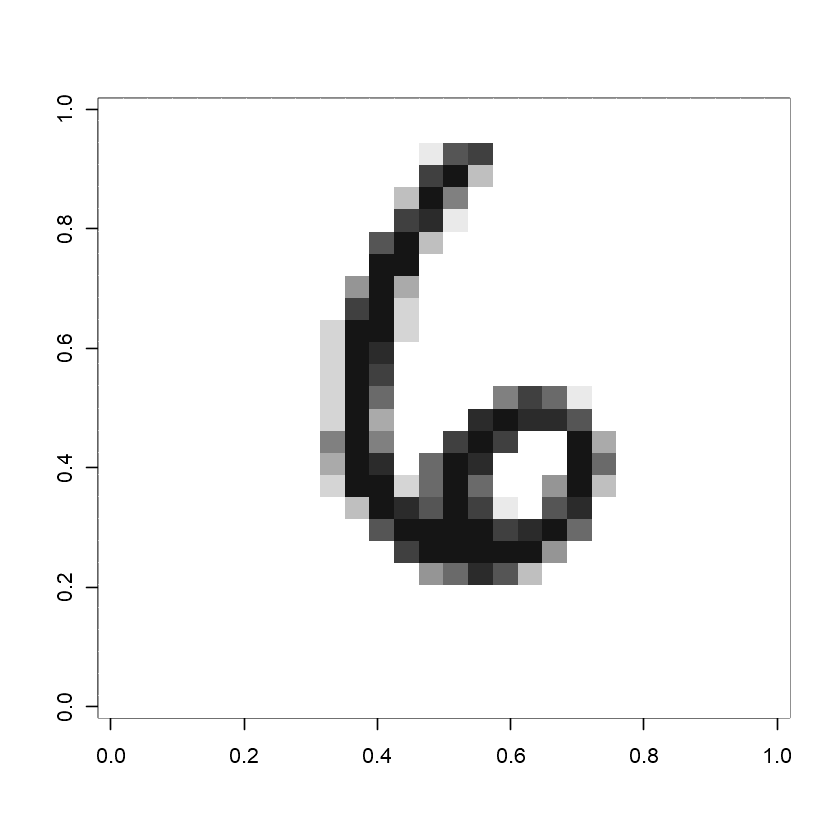

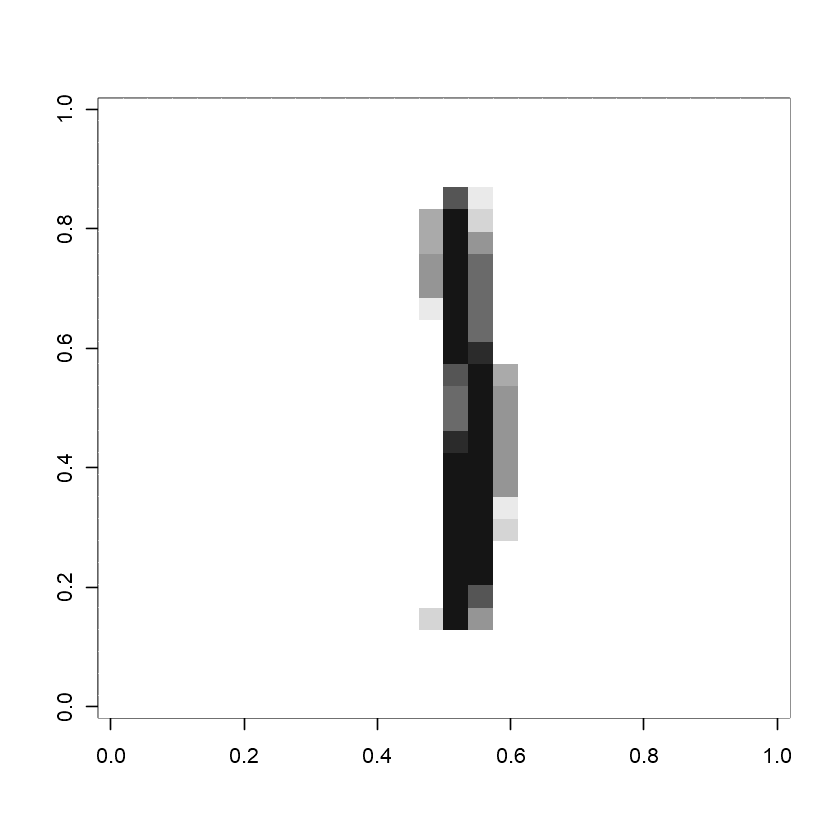

In [8]:
# train: el número 6
show_digit(train[41000, ])

# test: el número 1
show_digit(test[1000, ])

### Guardando los datos
De forma ordenada procedemos a guardar los datos en ficheros diferentes, uno por cada dígito ya identificado teniendo encuenta que hay dos conjuntos, uno de entrenamiento y otro de prueba

In [9]:
#*********************
## Guarda Rds
#*********************
if(!file.exists("./RDS")) {
      dir.create("RDS")
}

# train
for(i in 1:length(unique(train$label))){
      if(!file.exists(paste0("./RDS/Train_", i-1, ".rds"))) {
            saveRDS(filter(train, label==i-1), file = paste0("./RDS/Train_", i-1, ".rds"))
      }
}

# test
for(i in 1:length(unique(test$label))){
      if(!file.exists(paste0("./RDS/Test_", i-1, ".rds"))) {
            saveRDS(filter(test, label==i-1), file = paste0("./RDS/Test_", i-1, ".rds"))
      }
}


## Aplicando el SVM
Iniciamos por cargar únicamente la información deseada, teniendo cuidado de incluir los dos cojuntos, el de entrenamiento y el de prueba

In [12]:
## Cargue información. Dígitos 1 y 6
Train_1 <- readRDS("./RDS/Train_1.rds")
Train_6 <- readRDS("./RDS/Train_6.rds")

Test_1 <- readRDS("./RDS/Test_1.rds")
Test_6 <- readRDS("./RDS/Test_6.rds")

## Unificación train
train <- rbind(Train_1, Train_6)
train <- train %>% select(-(label))
y_train <- c(rep(1, dim(Train_1)[1]), rep(6, dim(Train_6)[1]))

## Unificación train
test <- rbind(Test_1, Test_6)
test <- test %>% select(-(label))
y_test <- c(rep(1, length(Test_1)), rep(6, length(Test_6)))

Verificamos que los datos leídos son los deseados

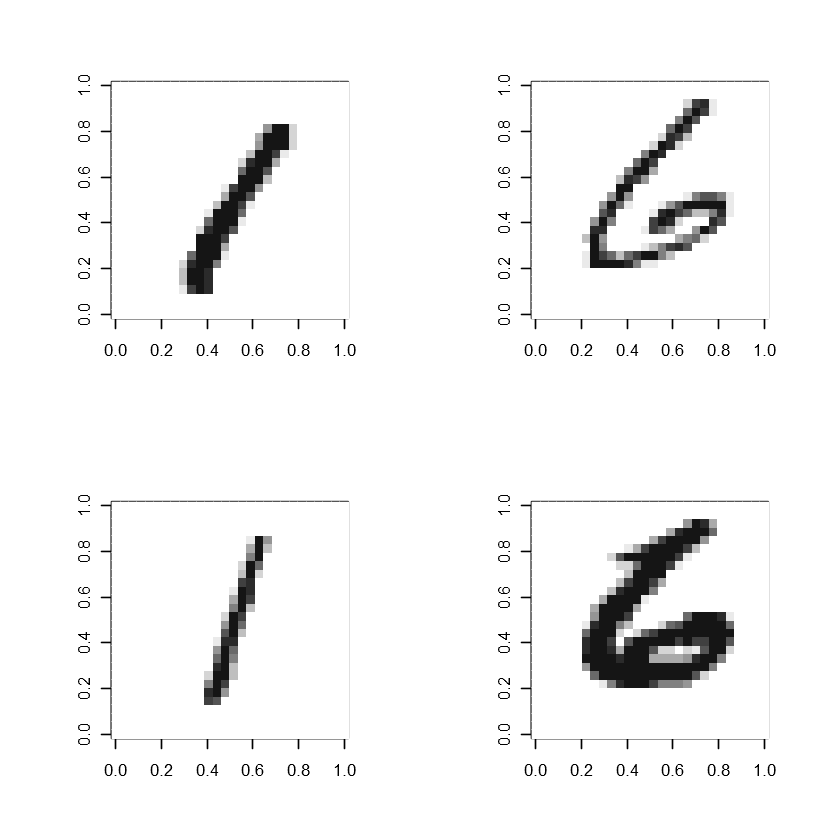

In [13]:
par(pty="s")
layout(matrix(1:4, 2, 2,byrow=TRUE))
show_digit(train[1,])
show_digit(train[nrow(train),])
show_digit(test[1,])
show_digit(test[nrow(test),])

En particular, resulta conveniente apoyarse del análisis de componentes principales, con el objetivo de reducir dimensionalidad en los datos y de esta manera facilitar el cálculo computacional. 

[1] 12660   784

[1] 7

[1] 31

[1] 64

[1] 117

[1] 271

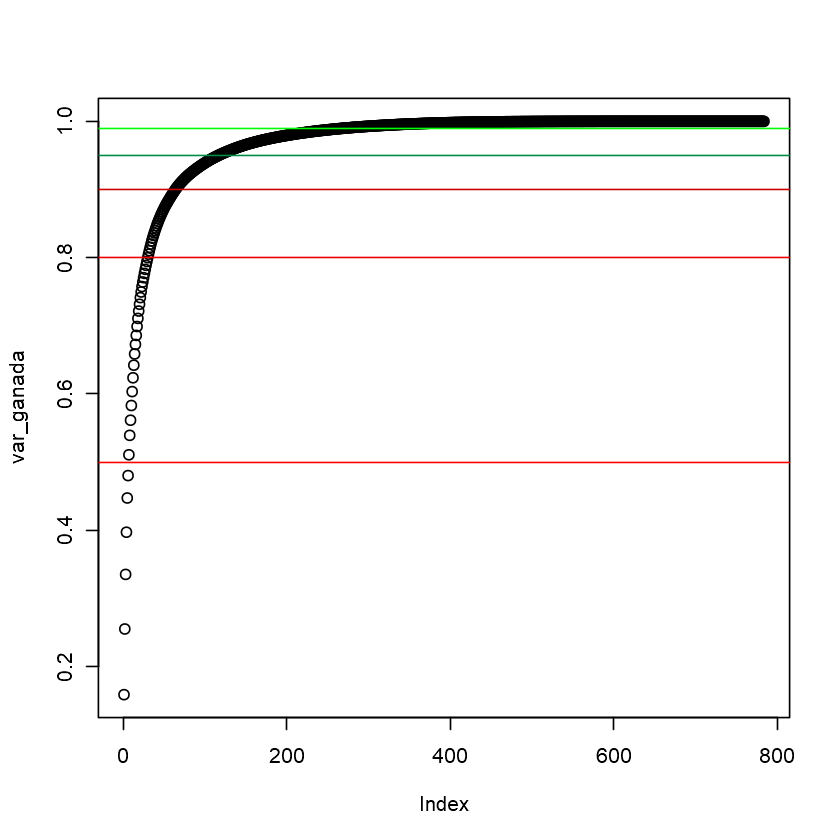

In [14]:
## Centrado de los datos
mean_train <- colMeans(train)
train <- train - mean_train

## Componentes principales
pc <- prcomp(train) 
pc_train <- pc$x
pc_test <- predict(pc, test)

## total componentes
dim(pc$x)

## Varianza ganada
var_ganada <- cumsum(pc$sdev^2)/sum(pc$sdev^2)
plot(var_ganada)
abline(h=0.5, col="red")
abline(h=0.8, col="red2")
abline(h=0.9, col="red3")
abline(h=0.95, col="springgreen4")
abline(h=0.99, col="green")

which(var_ganada>0.5)[1] # 7 componentes
which(var_ganada>0.8)[1] # 31 componentes
which(var_ganada>0.9)[1] # 64 componentes
which(var_ganada>0.95)[1] # 117 componentes
which(var_ganada>0.99)[1] # 271 componentes

El siguiente algoritmo ejecuta un SVM para cada combinación posible de parámetros, los cuales han sido definidos asi:
* Componentes: Número de componentes principales a utilizar
* Kernel: Tipo de kernel a contrastar linear, polynomial, radial y sigmoid.
* C: Costo asociado a la complejidad del modelo


In [15]:
if(!(file.exists("./results/resultados.RDS"))){
     resultados <- data.frame(Componentes=0, Kernel=0, C=0, err_train=0, err_test=0)
     Componentes <- c(2, 7, 31, 64, 117, 271)
     kernel <- c("linear", "polynomial", "radial", "sigmoid")
     C <- c(0.1, 1, 10, 100, 1000)
     
     require(progress)
     pb <- progress_bar$new(total = length(Componentes))
     for(k in Componentes){
               for(i in kernel){
                         for(j in C){
                                   model_svm <- svm(pc_train[,1:k], as.factor(y_train), kernel = i, cost = C)
                                   predictivas_train <- predict(model_svm, pc_train[,1:k])
                                   predictivas_test <- predict(model_svm, pc_test[,1:k])
                                   residuales_train <- ifelse(y_train == predictivas_train, 0, 1)
                                   residuales_test <- ifelse(y_test == predictivas_test, 0, 1)
                                   err_train <- mean(residuales_train)
                                   err_test <- mean(residuales_test) 
                                   resultados <- rbind(resultados, c(k, i, j, err_train, err_test))
                                   }
                              }
                         pb$tick()
                         }
     
     ## Tabla de resultados
     resultados <- resultados[-1,]
     resultado <- resultados
     resultados$iteraciones <- c(1:nrow(resultados)) 
     resultados$err_train <- as.numeric(resultados$err_train)
     resultados$err_test <- as.numeric(resultados$err_test)
     
     saveRDS(resultados, file = "./results/resultados.RDS")
     
     ## Si ya se ha calculado previamente
     } else {
            resultados <- readRDS("./results/resultados.RDS")
            }

La siguiente gráfica muestra los resultados de las estimaciones para cada combinación de parámetros

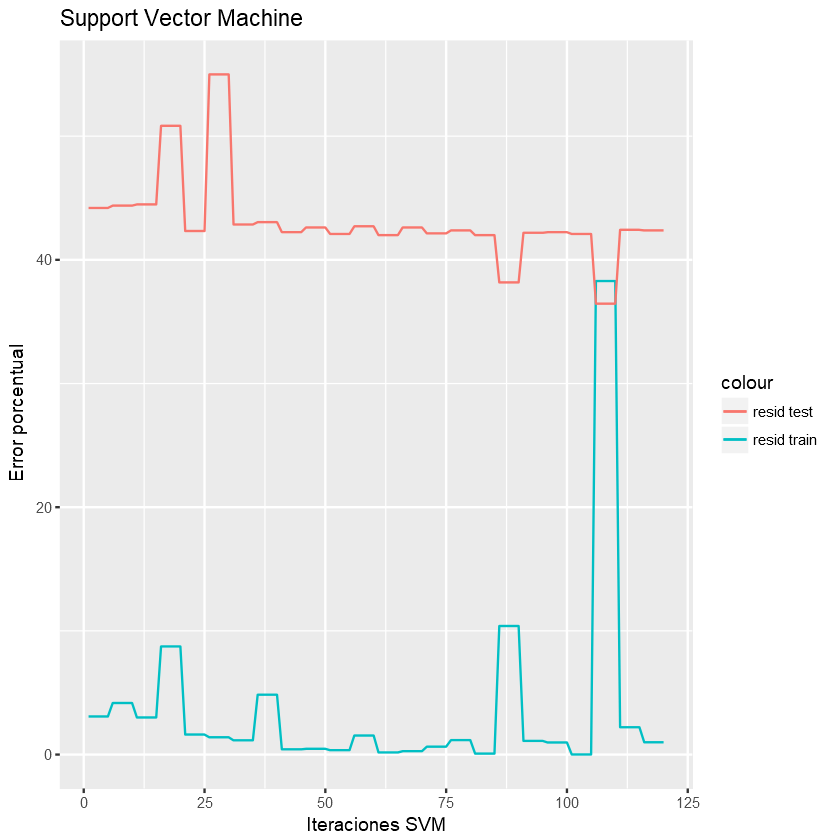

In [21]:
require(ggplot2)
ggplot(resultados, aes(x=iteraciones, y=err_train*100, colour="resid train")) + geom_line() +
      geom_line(aes(x=iteraciones, y=err_test*100, colour="resid test")) + xlab("Iteraciones SVM") +
      ylab("Error porcentual") + labs(title = "Support Vector Machine")

El mejor resultado se obtiene a continuación:

In [22]:
resultados[which.min(resultados$err_test), ]

,Componentes,Kernel,C,err_train,err_test,iteraciones
107,271,polynomial,0.1,0.3828594,0.3645485,106
